## Determining SV causality using Information Gain

Encoded CSV saved as: ofc_gene_encoded.csv

Entropy of target column 'phenotype1': 0.7219

Information gain for 'age': 0.1710
Information gain for 'IRF8': 0.7219
Information gain for 'SOX6': 0.0000
Information gain for 'JUN': 0.7219
Information gain for 'C1': 0.1710
Information gain for 'C2': 0.1177
Information gain for 'C3': 0.2690
Information gain for 'C4': 0.2690
Information gain for 'C3_4': 0.7219
Information gain for 'sex': 0.1177
Information gain for 'lineage': 0.4464
Information gain for 'phenotype1': 0.7219
Information gain for 'phenotype2': 0.4464


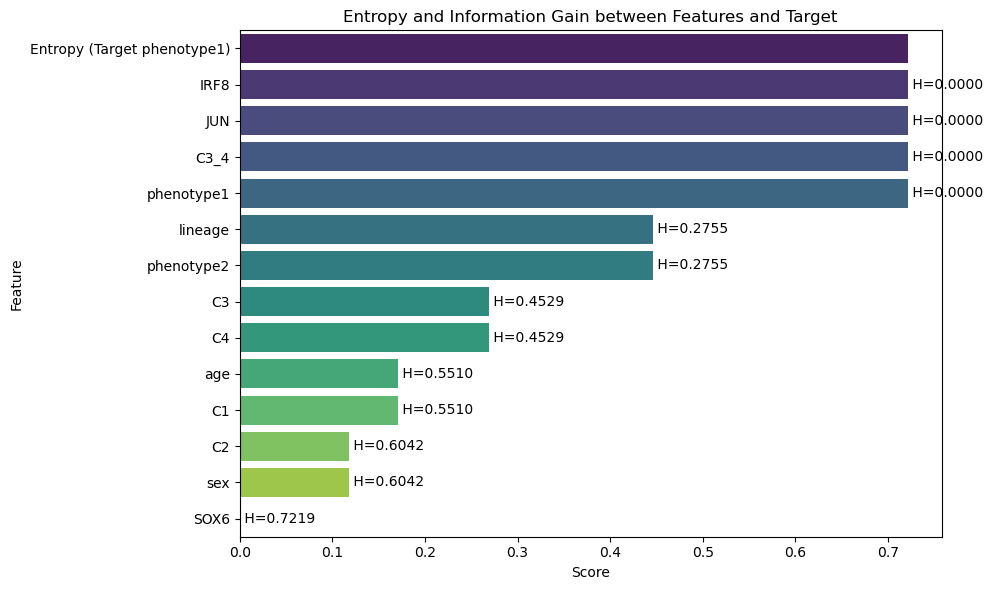

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import entropy as scipy_entropy

def entropy(column):
    value, counts = np.unique(column, return_counts=True)
    probs = counts / len(column)
    return scipy_entropy(probs, base=2)

def information_gain(data, feature, target):
    original_entropy = entropy(data[target].values)
    total_rows = len(data)
    weighted_entropy = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        prob = len(subset) / total_rows
        weighted_entropy += prob * entropy(subset[target].values)
    return original_entropy - weighted_entropy

def conditional_entropy(data, feature, target):
    total = len(data)
    ce = 0.0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        prob = len(subset) / total
        ce += prob * entropy(subset[target].values)
    return ce
    
# Load your data (assumes first row is header)
df = pd.read_csv('ofc_gene.csv')  

# Encode non-numeric categorical columns as integers and save mappin
for col in df.columns:
    if df[col].dtype == 'object':
        df[col], _ = pd.factorize(df[col])

# Save encoded DataFrame to a new CSV for inspection
encoded_file = 'ofc_gene_encoded.csv'
df.to_csv(encoded_file, index=False)
print(f"Encoded CSV saved as: {encoded_file}\n")

# Get column headers from the DataFrame
all_columns = df.columns.tolist()
# target_col = all_columns[-1]  # Assumes last column is target
target_col = all_columns[-3]  # Assumes last column is target
features = all_columns[:-1]   # All columns except the last

# Print entropy of the target column
target_entropy = entropy(df[target_col].values)
print(f"Entropy of target column '{target_col}': {target_entropy:.4f}\n")

# Compute and print information gain for each feature
for feature in features:
    ig = information_gain(df, feature, target_col)
    print(f"Information gain for '{feature}': {ig:.4f}")

### Visualization
import pandas as pd
import numpy as np
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate conditional entropy for each feature and add to DataFrame
ig_results = []
for feature in features:
    ig = information_gain(df, feature, target_col)
    ce = conditional_entropy(df, feature, target_col)
    ig_results.append({
        'Feature': feature,
        'Score': ig,
        'Conditional Entropy': ce
    })

# Add target entropy as a row (optional, as before)
ig_results.append({
    'Feature': f"Entropy (Target {target_col})",
    'Score': target_entropy,
    'Conditional Entropy': float('nan')  # Not applicable
})

ig_df = pd.DataFrame(ig_results)

# Sort so "Entropy (Target)" is first, then the rest by descending score
ig_df['Is_Entropy'] = ig_df['Feature'].str.startswith('Entropy')
ig_df = ig_df.sort_values(['Is_Entropy', 'Score'], ascending=[False, False]).drop('Is_Entropy', axis=1)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Score', 
    y='Feature', 
    data=ig_df, 
    hue='Feature', 
    palette='viridis', 
    legend=False
)

# Annotate each bar with conditional entropy (if not the target entropy row)
for i, (feature, ce) in enumerate(zip(ig_df['Feature'], ig_df['Conditional Entropy'])):
    if not feature.startswith('Entropy'):
        ax.text(
            x=ig_df['Score'].iloc[i],  # Position at the end of the bar
            y=i,                        # Y position (bar index)
            s=f" H={ce:.4f}",           # Text to display
            va='center',                # Vertical alignment
            ha='left',                  # Horizontal alignment
            color='black'
        )

plt.title('Entropy and Information Gain between Features and Target')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()